In [2]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [4]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [5]:
sess = tf.InteractiveSession()

In [92]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3

# define placeholders 
x = tf.placeholder(tf.float32, [None, len(symbol_list) * 100])
y_ = tf.placeholder(tf.float32, [None,  len(symbol_list)])

# define trainable variables
W = tf.Variable(tf.random_normal([len(symbol_list) * 100, num_positions * len(symbol_list)]))
b = tf.Variable(tf.random_normal([num_positions * len(symbol_list)]))

# we define our model: y = W*x + b
y = tf.matmul(x, W) + b # y is tensor of shape [num_inputs, num_positions * len(symbol_list)]
# a row of y will look like [prob_symbol_1_short, prob_symbol_1_neutral, prob_symbol_1_long, prob_symbol_2_short, ...]
# note that they are not really probabilities because I did not perform a softmax yet


# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(len(symbol_list)):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), 1)#sample = tf.argmax(symbol_probs_softmax, 1) #use a real sample
    pos[i] = tf.reshape(sample, [-1]) - 1   # choose(-1,0,1)
    # get returns by multiplying the policy (position taken) by the target return for that day
    symbol_returns[i] = tf.mul(tf.cast(pos[i], float32),  y_[:,i])
    # isolate the probability of the selected policy (for use in calculating gradient)
    sample_mask = tf.reshape(tf.one_hot(sample, 3), [-1,3])
    relevant_target_column[i] = tf.reduce_sum(symbol_probs * sample_mask,1) # should be relevant to SAMPLE
    
# calculate the performance metrics for the data chosen
daily_returns_by_symbol = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns = tf.reduce_sum(daily_returns_by_symbol,1)/2
total_return = tf.reduce_prod(daily_returns + 1)
ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns)),2))) ,
    np.sqrt(252)
    )
sharpe = total_return / ann_vol

# since we only train the sampled classes, we will combine them so that we can feed them into cross entropy
training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
# we want to either push the gradient toward our selection or away from it. We use these ones to find the direction
#     of the gradient, which we will then multiply by our fitness function
ones = tf.ones_like(training_target_cols)

# this isnt actuall a gradient, but karpathy sort of calls it one. Since it is a tensor it sort of is a gradient anyway
gradient = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

# how should we do this step? it depends how we want to group our results. Choose your own adventure here by uncommenting a cost fn
# this is the most obvious: we push each weight to what works or not. Try it out...we're gonna be RICH!!!! oh, wait...
#cost = tf.mul(gradient , daily_returns_by_symbol)
# this takes the overall daily return and pushes the weights so that the overall day wins. Again, it overfits enormously
#cost = tf.mul(gradient , tf.reshape(daily_returns,[-1,1]))
# this multiplies every gradient by the overall return. If the strategy won for the past ten years, we do more of it and vice versa
cost = tf.mul(gradient , total_return)
costfn = tf.reduce_mean(cost)


opt = tf.train.GradientDescentOptimizer(0.05)
grads = opt.compute_gradients(cost)

# minimize the cost (push the weights where we want them to go)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
#opt = tf.train.GradientDescentOptimizer(0.05).compute_gradients(loss)

In [93]:
grads

[(None, <tensorflow.python.ops.variables.Variable at 0x1038e45f8>),
 (None, <tensorflow.python.ops.variables.Variable at 0x10e2346a0>),
 (None, <tensorflow.python.ops.variables.Variable at 0x110d9da58>),
 (None, <tensorflow.python.ops.variables.Variable at 0x110c97ac8>),
 (None, <tensorflow.python.ops.variables.Variable at 0x111b70a20>),
 (None, <tensorflow.python.ops.variables.Variable at 0x111b5c978>),
 (None, <tensorflow.python.ops.variables.Variable at 0x110f9dd68>),
 (None, <tensorflow.python.ops.variables.Variable at 0x110fa0390>),
 (None, <tensorflow.python.ops.variables.Variable at 0x112d29f60>),
 (None, <tensorflow.python.ops.variables.Variable at 0x112d296a0>),
 (None, <tensorflow.python.ops.variables.Variable at 0x1142d8c88>),
 (None, <tensorflow.python.ops.variables.Variable at 0x1142dacf8>),
 (None, <tensorflow.python.ops.variables.Variable at 0x114769be0>),
 (None, <tensorflow.python.ops.variables.Variable at 0x114776c88>),
 (None, <tensorflow.python.ops.variables.Variabl

In [89]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(20000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,10)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%1000== 0:
        c,t = sess.run([costfn, total_return], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), "total return=", "{:.9f}".format(t-1))

Epoch: 1000 cost= 0.003873809 total return= -0.700455070
Epoch: 2000 cost= 0.001323001 total return= -0.613465220
Epoch: 3000 cost= 0.000658309 total return= -0.733679563
Epoch: 4000 cost= 0.000732141 total return= -0.648655087
Epoch: 5000 cost= 0.001373451 total return= -0.331434786
Epoch: 6000 cost= 0.000790576 total return= -0.626077503
Epoch: 7000 cost= 0.000348340 total return= -0.737101316
Epoch: 8000 cost= 0.000255199 total return= -0.750297233
Epoch: 9000 cost= 0.000277444 total return= -0.740910947
Epoch: 10000 cost= 0.000290456 total return= -0.750384808
Epoch: 11000 cost= 0.000287876 total return= -0.664480180
Epoch: 12000 cost= 0.000298037 total return= -0.657870382
Epoch: 13000 cost= 0.000122848 total return= -0.797136217
Epoch: 14000 cost= 0.000231139 total return= -0.639020383
Epoch: 15000 cost= 0.000160102 total return= -0.699135631
Epoch: 16000 cost= 0.000119351 total return= -0.736051410
Epoch: 17000 cost= 0.000136958 total return= -0.775251120
Epoch: 18000 cost= 0.00

In [81]:
# in sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: train_ins, y_: train_outs})

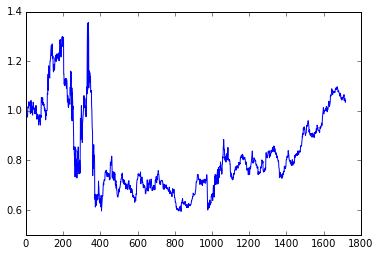

In [82]:
# equity curve
plot(np.cumprod(d+1))

In [83]:
#out of sample results
d, t = sess.run([daily_returns, gradient], feed_dict={x: test_ins, y_: test_outs})

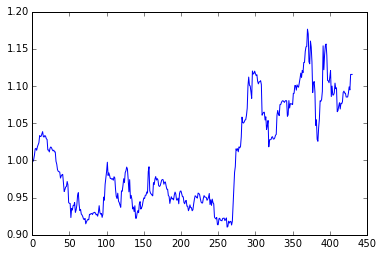

In [84]:
#out of sample results
plot(np.cumprod(d+1))